## Info general del proyecto:

Slack: 

www.piashiba.slack.com



Acceso a datos:

Data cannot be shared publicly because of regulation of institutional review board of Far Eastern Memorial Hospital. Data are available from the institutional review board (contact via phone: +886-2-8966-7000 ext. 2152 and the e-mail: .wt.gro.hmef.liam@bri) for researchers who meet the criteria for access to confidential data. Alternatively, we uploaded the images labeled by our proposed methods (boundary-based and region-based) to the data repository site. The DOIs by two different methods are S1 Dataset. Region-based label method https://doi.org/10.6084/m9.figshare.17206904.v1 and S2 Dataset. Boundary-based label method https://doi.org/10.6084/m9.figshare.17206940.v1. The images are collected from the open dataset of wound, the Medetec. Those labeled images were part of our testing sets. Researchers can train DL models with these two datasets to replicate our study results.

Far Eastern Memorial Hospital (Taiwan):

https://www.femh.org.tw/MainPage_en/contactinfor

También estaba este otro mail, que es al que le mandé porque el anterior no existe al parecer:

irb@mail.femh.org.tw

Paper: 

https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0264139

## Conecto a carpeta de Drive y creo paths y carpetas iniciales:

In [ ]:
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/pIASHIBA Proyecto /Datos/Medetec cambiados/Medetec Labeled_2.zip', 'r') as zip_ref: # Me crea las carpetas en content, a partir del .zip
    zip_ref.extractall('.')


In [ ]:
import os 
import re
from pathlib import Path
pathS1 = Path('./Medetec Labeled_2/S1 Dataset') # dentro del zip hay una carpeta q es Medetec Labeled_2
pathS1

PosixPath('Medetec Labeled_2/S1 Dataset')

In [ ]:
from PIL import Image
import numpy as np
from numpy import asarray


p = Path(pathS1/'Fotos1npy')
p.mkdir(parents=True, exist_ok=True)
for i in os.listdir(pathS1/'Fotos1'):
   img = Image.open(f"/content/Medetec Labeled_2/S1 Dataset/Fotos1/{i}")
   numpydata = asarray(img)
   npyfile = p/i.split(".")[0]
   np.save(npyfile, numpydata)


p2 = Path(pathS1/'Segmentationsnpy')
p2.mkdir(parents=True, exist_ok=True)
for i in os.listdir(pathS1/'Segmentations'):
   img = Image.open(f"/content/Medetec Labeled_2/S1 Dataset/Segmentations/{i}")
   numpydata = asarray(img)
   npyfile = p2/i.split(".")[0]
   np.save(npyfile, numpydata)  



In [ ]:
imgs = [pathS1/"Fotos1npy"/i for i in os.listdir(pathS1/'Fotos1npy')]
ixs = [i.split('-')[-1] for i in os.listdir(pathS1/'Fotos1npy')] # me da lo q esta desp del guión empezando de atras
# me separa el string en una lista  y me quedo con el último elemento [-1]

ixs_sin_jpg = [re.split(r"\D", i)[-5] for i in os.listdir(pathS1/'Fotos1npy')] # creo esto xq los archivos de segmentation no terminan en número.jpg, sino que son número_mask.jpg
# ESTO SERIA ixs_sin_npy IUGAL NO HACE FALTA XQ USO DE REFERENCIA EL NOMBRE COMPLETO DEL ARCHIVO.

ixs_referencia = [i.split('.')[0] for i in os.listdir(pathS1/'Fotos1npy')]

masks = [pathS1/'Segmentationsnpy'/f'{ix}_mask.npy' for ix in ixs_referencia]
# Los siguientes paths los puedo crear aunque todavía no existan. Me sirve despues para que ya esté todo referenciado y ordenado.
masksRGBPuros = [pathS1/'SegmentationsRGBPuronpy'/f'{ix}_mask.npy' for ix in ixs_referencia] # guardo los archivos .npy creados en mask según la referencia que coincida con imgs.
masksClaseX1 = [pathS1/'SegmentationsClaseX1'/f'{ix}_mask.npy' for ix in ixs_referencia]
masksClaseXN = [pathS1/'SegmentationsClaseXN'/f'{ix}_mask.npy' for ix in ixs_referencia]

len(imgs), len(masks), len(masksRGBPuros)




(17, 17, 17)

## Pre-procesamiento: segmentations con channel de RGB (no puro) a (clases OH para train):
Hay un problema que es que las segmentations no vienen dadas directamente para entrenamiento (con 3er dimensión (channel) según la cant de clases o onehotencoded), sino que vienen en RGB. 

Con lo cual tendría que ver a qué color corresponde cada clase y pasar de RGB a los números (índice) de cada clase de tejido. Por ejemplo, programar que todos los píxeles que están en color rojo [255,0,0] corresponden al tejido Granulation y por lo tanto les reemplazo el RGB por la clase correspondiente para poder usarlo como label y entrenar después (aplicándole onehotencoding). 

Acá hay otro problema que es que las segmentations no vienen dadas en colores de RGB puros, es decir, el rojo por ejemplo no siempre es [255,0,0], si no que a veces aparece por ejemplo como [253,0,1] , con lo cual primero habría que pasar estos RGB no puros a RGB puros, para después sí, poder definir cada RGB puro como una clase particular para poder entrenar el modelo.

### Paso imágenes de RGB a RGB puro y creo carpeta:

Otra forma hubiera sido usando ifs para una entrada RGB q lea cada valor y si es mayor por ejemplo a 127 entonces =255, si es menor entonces = 0, xq todos los valores son o 0 o 255, quizas sea bastante mas rapido para correr.



```

# Apply threshold to an image
def thresholding(data, threshold):
    output = np.copy(data)
    for x in range(0, data.shape[0]):
        for y in range(0, data.shape[1]):
            for z in range(0, data.shape[2]):
                    if data[x,y,z] > threshold:
                        output[x,y,z] = data[x,y,z]
                    else:
                        output[x,y,z] = 0
    return output
```



In [ ]:
def RGB2RGBPuro(RGB):

    listaIdColor = []

    Negro = np.array([0,0,0])
    Azul = np.array([0,0,255]) 
    Rojo = np.array([255,0,0])
    Amarillo = np.array([255,255,0])
    Blanco = np.array([255,255,255])

    listaRGBPuros = [Negro, Azul, Rojo, Amarillo, Blanco]

    for RGBPuro in listaRGBPuros:      # agrego a la listaIdColor los valores que me identifican de qué color se trata. El más parecido a RGBPuro va a ser el más cercano a 0 (el mínimo de la lista)    
          if (RGB == RGBPuro).all():
             return RGB # si ya es puro, q me lo retorne nomas, esto hace que la operación dure bastante tiempo menos cuando la corro abajo.

    for RGBPuro in listaRGBPuros:      # agrego a la listaIdColor los valores que me identifican de qué color se trata. El más parecido a RGBPuro va a ser el más cercano a 0 (el mínimo de la lista)    
         listaIdColor.append( abs((RGB  - RGBPuro)).dot([1,1,1])  )  
                      
    for count, RGBPuro in enumerate(listaRGBPuros, start = 0): # veo la posición de la lista donde está el mínimo de forma iterativa. "Si el mínimo está en la posición 0, entonces es Negro, si está en la 1, entonces es Azul y así..."
      if np.where(listaIdColor == np.amin(listaIdColor))[0] == count:
          RGB = RGBPuro

    return RGB


labelsPuros = []
for i in range (len(masks)): # i va a tomar valores de 0 a 16
   mask = np.load(masks[i])
   for h in range (mask.shape[0]-1): # itero por height, si la shape de la mask es por ejemplo (482, 560, 3), h debe tomar valores entre 0 y 481. (las shapes no son todas iguales...)
     for w  in range (mask.shape[1]-1):
       mask[h][w] = RGB2RGBPuro(mask[h][w])
   labelsPuros.append(np.array(mask))





In [ ]:
p3 = Path(pathS1/'SegmentationsRGBPuronpy')
p3.mkdir(parents=True, exist_ok=True)
for count, i in enumerate(os.listdir(pathS1/'Segmentations')):
   #print(count)
   
   numpydata = labelsPuros[count] # le cargo los datos son RGBPuro
   #npyfile = p3/i.split(".")[0] # Para que tome el nombre del archivo que quiero, en el path que quiero
   npyfile = str(masksRGBPuros[count]).split(".")[0]
   np.save(npyfile, numpydata)  
   print(npyfile)



Medetec Labeled_2/S1 Dataset/SegmentationsRGBPuronpy/healing-pressure-ulcer-0013_mask
Medetec Labeled_2/S1 Dataset/SegmentationsRGBPuronpy/sloughy-presure-ulcer-0036_mask
Medetec Labeled_2/S1 Dataset/SegmentationsRGBPuronpy/pressure-ulcer-on-foot-0006_mask
Medetec Labeled_2/S1 Dataset/SegmentationsRGBPuronpy/sloughy-pressure-ulcer-0008_mask
Medetec Labeled_2/S1 Dataset/SegmentationsRGBPuronpy/pressure-ulcer-on-neck-0002_mask
Medetec Labeled_2/S1 Dataset/SegmentationsRGBPuronpy/sloughy-pressure-ulcer-0028_mask
Medetec Labeled_2/S1 Dataset/SegmentationsRGBPuronpy/sloughy-pressure-ulcer-0024_mask
Medetec Labeled_2/S1 Dataset/SegmentationsRGBPuronpy/pressure-ulcer-on-foot-0008_mask
Medetec Labeled_2/S1 Dataset/SegmentationsRGBPuronpy/pressure-ulcer-on-foot-0032_mask
Medetec Labeled_2/S1 Dataset/SegmentationsRGBPuronpy/pressure-ulcer-on-foot-0013_mask
Medetec Labeled_2/S1 Dataset/SegmentationsRGBPuronpy/pressure-ulcer-on-foot-0027_mask
Medetec Labeled_2/S1 Dataset/SegmentationsRGBPuronpy/sl

### Grafico para chequear que las fotos coincidan con los labels:

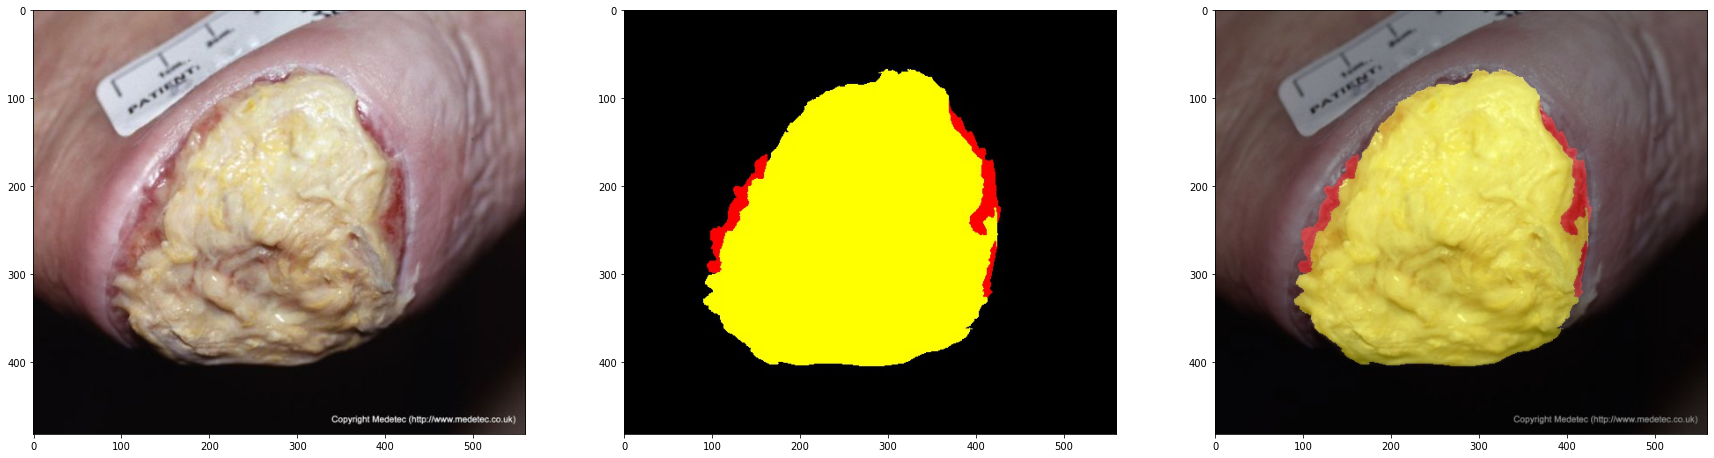

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))
nroImg = 2
img = np.load(imgs[nroImg])
mask = np.load(masks[nroImg])
maskRGBPuro = np.load(masksRGBPuros[nroImg]) # para confirmar que se vea como mask.
#maskClaseX1 = np.load(masksClaseX1[nroImg])
#maskHxW = np.squeeze(maskClaseX1, axis=2)


ax1.imshow(img)
ax2.imshow(mask)
ax3.imshow(img)
ax3.imshow(mask, alpha=0.4)
plt.show()


In [ ]:
img.shape, img.dtype, img.max(), img.min()

((482, 560, 3), dtype('uint8'), 255, 0)

In [ ]:
mask.shape, mask.dtype, mask.max(), mask.min()
# (alto, ancho, canales)

((482, 560, 3), dtype('uint8'), 255, 0)

In [ ]:
maskRGBPuro.shape, maskRGBPuro.dtype, maskRGBPuro.max(), maskRGBPuro.min()

((482, 560, 3), dtype('uint8'), 255, 0)

### Analizo Relación Color-Tejido(Clase)
Como las segmentations no tienen aclaración de a qué tejido corresponde cada color, comparo con imágen de annotations (el otro dataset), que en el .json sí aclara a qué tejido corresponde cada polígono.
Quizás esto no es tan útil pero lo hago también más que nada para ver de qué se trata el otro dataset que tiene todo en .json .

Uso la siguiente imagen [1], aprovechando que tiene todos los tejidos: (el índice de la imágen cambia según como se cargó arriba en las carpetas, pero es la del link)

https://figshare.com/articles/dataset/healing-pressure-ulcer-0013_jpg/17206904/1?file=31798349

A partir de las annotation, de esa imagen, en .json:

https://figshare.com/articles/dataset/images_of_pressure_ulcer_2_/17206940/1?file=31798520

, trazo los polígonos correspondientes a cada tejido con sus referencias y comparo con la imágen segmentada, para identificar cada tejido junto a su color:

Una vez en RGBPuro las clases quedarían:

Azul: [0,0,255] --> Eschar

Amarillo: [255,255,0] --> Slough Tissue

Rojo: [255,0,0] --> Granulation

Blanco: [255,255,255] --> Re-ep

Negro: [0,0,0] --> Background


Ulceration sería la unión de Eschar, Slough Tissue y Granulation.


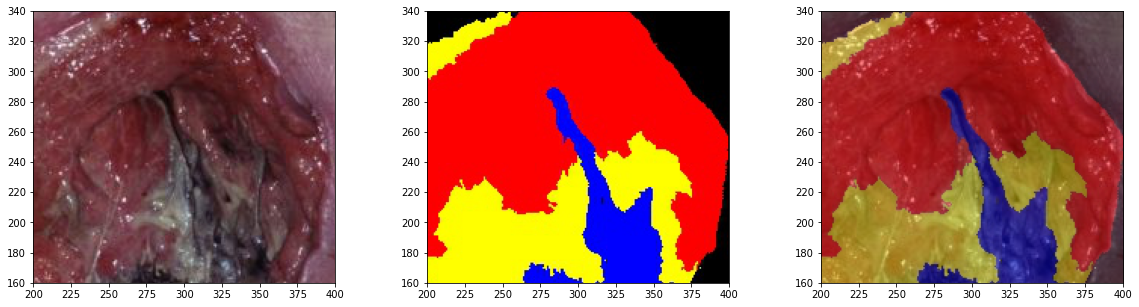

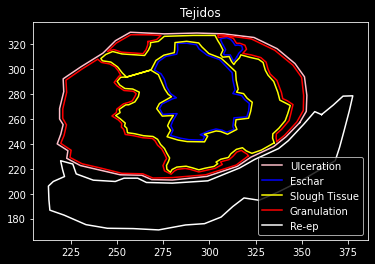

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
#https://figshare.com/articles/dataset/images_of_pressure_ulcer_2_/17206940/1?file=31798520

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,5))
nroImg = 1
img = np.load(imgs[nroImg])
mask = np.load(masks[nroImg])
ax1.imshow(img)
ax2.imshow(mask)
ax3.imshow(img)
ax3.imshow(mask, alpha=0.4)

# Defino los limites para que coincidan con la imagen con los poligonos y annotations, para comparar mejor:
xlim = [200, 400]
ylim = [160, 340]
ax1.set_xlim(xlim)
ax1.set_ylim(ylim)
ax2.set_xlim(xlim)
ax2.set_ylim(ylim)
ax3.set_xlim(xlim)
ax3.set_ylim(ylim)

#plt.xlim( [ 0, 80 ] )          # Plot from x=0 to x=80.
#plt.ylim( [ 0, 250 ] )         # Plot from y=0 to y=250.
plt.show()
# shape img[2]: (406, 560, 3)

#bordes = [[0,0],[560,0],[560,406],[0,406]] # esto era para q coincidiera con la imagen original, pero despues con xlim , ylim no hace falta.
#bordes.append(bordes[0])

ulceration = [[348.8745980707396,256.9131832797428],[341.4790996784566,245.65916398713827],[334.7266881028939,237.62057877813507],[322.508038585209,229.2604501607717],[315.1125401929261,221.86495176848877],[298.7138263665595,213.82636655948554],[280.06430868167206,210.93247588424438],[268.8102893890675,211.2540192926045],[263.34405144694534,214.79099678456592],[251.7684887459807,215.11254019292605],[240.51446945337622,218.97106109324758],[230.2250803858521,222.50803858520902],[222.82958199356915,228.29581993569133],[223.4726688102894,234.40514469453376],[217.68488745980707,239.87138263665597],[219.61414790996784,247.58842443729904],[220.90032154340838,255.30546623794214],[218.97106109324758,259.80707395498393],[218.97106109324758,268.16720257234726],[221.2218649517685,281.6720257234727],[220.90032154340838,291.9614147909968],[230.54662379421222,301.60771704180064],[242.443729903537,312.54019292604505],[249.19614147909968,322.508038585209],[257.2347266881029,329.2604501607717],[275.5627009646302,327.9742765273312],[293.2475884244373,328.61736334405145],[307.7170418006431,327.9742765273312],[324.11575562700966,325.08038585209005],[336.65594855305466,316.07717041800646],[346.30225080385856,304.18006430868166],[351.4469453376206,293.56913183279744],[352.7331189710611,278.77813504823155],[352.411575562701,265.91639871382637]]
ulceration.append(ulceration[0]) #repeat the first point to create a 'closed loop'

eschar = [[297.42063492063494,245.83333333333334],[295.03968253968253,247.22222222222223],[299.6031746031746,250.1984126984127],[303.57142857142856,251.78571428571428],[306.94444444444446,250.79365079365078],[309.3253968253968,249.20634920634922],[313.2936507936508,251.38888888888889],[312.6984126984127,253.96825396825398],[313.2936507936508,260.7142857142857],[320.23809523809524,261.5079365079365],[321.23015873015873,266.26984126984127],[321.6269841269841,272.22222222222223],[319.04761904761904,275.3968253968254],[317.46031746031747,278.57142857142856],[312.6984126984127,280.1587301587302],[313.8888888888889,283.13492063492066],[312.6984126984127,290.87301587301585],[312.3015873015873,296.8253968253968],[308.92857142857144,302.1825396825397],[305.55555555555554,307.3412698412698],[298.8095238095238,310.91269841269843],[294.44444444444446,315.87301587301585],[293.05555555555554,319.24603174603175],[287.8968253968254,320.43650793650795],[282.73809523809524,320.43650793650795],[282.93650793650795,315.07936507936506],[282.3412698412698,311.7063492063492],[276.3888888888889,309.92063492063494],[272.42063492063494,305.75396825396825],[270.23809523809524,299.0079365079365],[273.8095238095238,296.031746031746],[275.5952380952381,291.86507936507934],[276.984126984127,285.1190476190476],[278.968253968254,280.1587301587302],[282.14285714285717,276.7857142857143],[280.1587301587302,275.9920634920635],[274.4047619047619,271.8253968253968],[273.015873015873,268.25396825396825],[274.8015873015873,263.4920634920635],[278.76984126984127,263.8888888888889],[282.53968253968253,264.08730158730157],[280.1587301587302,258.13492063492066],[279.1666666666667,254.36507936507937],[280.35714285714283,250.79365079365078],[278.968253968254,246.62698412698413],[284.3253968253968,244.44444444444443],[288.8888888888889,243.25396825396825],[296.42857142857144,242.85714285714286]] 
eschar.append(eschar[0])
eschar2 = [[315.0,309.8],[315.9,312.4],[318.0,315.5],[317.5,318.4],[315.5,319.0],[314.0,318.7],[312.8,321.4],[311.4,323.7],[309.4,324.9],[307.1,324.4],[305.9,323.8],[306.9,320.4],[308.8,315.3],[307.6,311.7],[308.2,311.1],[311.3,311.1],[312.7,307.2],[313.1,305.8]]
eschar2.append(eschar2[0])

slough_tissue = [[335.04901960784315,240.68627450980392],[334.19117647058823,244.48529411764704],[334.3137254901961,247.91666666666666],[337.62254901960785,252.45098039215685],[341.05392156862746,258.578431372549],[342.4019607843137,264.09313725490193],[343.75,270.5882352941176],[341.421568627451,272.4264705882353],[338.1127450980392,274.87745098039215],[337.0098039215686,281.12745098039215],[334.80392156862746,289.828431372549],[331.7401960784314,294.8529411764706],[330.26960784313724,298.77450980392155],[329.04411764705884,305.02450980392155],[326.59313725490193,307.59803921568624],[321.8137254901961,309.19117647058823],[317.03431372549016,311.1519607843137],[316.29901960784315,308.8235294117647],[314.2156862745098,305.6372549019608],[313.2352941176471,303.4313725490196],[312.0098039215686,305.7598039215686],[310.6617647058823,309.80392156862746],[307.23039215686276,309.3137254901961],[306.12745098039215,311.1519607843137],[307.3529411764706,314.95098039215685],[305.88235294117646,319.3627450980392],[304.53431372549016,322.54901960784315],[303.0637254901961,326.7156862745098],[291.29901960784315,326.7156862745098],[275.6127450980392,325.98039215686276],[272.4264705882353,321.9362745098039],[268.1372549019608,320.95588235294116],[268.1372549019608,318.5049019607843],[267.03431372549016,314.95098039215685],[264.95098039215685,310.6617647058823],[258.94607843137254,311.27450980392155],[252.69607843137254,311.8872549019608],[247.67156862745097,313.84803921568624],[243.9950980392157,311.51960784313724],[241.29901960784312,308.21078431372547],[242.15686274509804,306.37254901960785],[246.69117647058823,305.3921568627451],[250.36764705882354,301.4705882352941],[252.8186274509804,296.8137254901961],[255.14705882352942,293.38235294117646],[268.4,299.0],[271.1,306.7],[275.4,310.9],[281.0,312.9],[281.2,315.0],[281.4,321.0],[287.7,322.0],[294.2,320.7],[295.9,317.6],[299.7,312.2],[306.4,308.4],[310.4,303.0],[314.2,297.7],[314.5,291.0],[315.6,283.6],[314.7,281.3],[318.5,280.1],[320.5,276.3],[323.2,273.2],[322.3,265.8],[321.2,260.4],[314.4,259.2],[314.0,254.8],[314.9,251.5],[309.8,247.6],[306.1,249.8],[303.6,250.2],[300.6,248.9],[297.3,247.5],[299.1,246.1],[297.4,241.5],[288.0,241.7],[283.1,242.9],[277.1,245.6],[279.0,250.7],[277.4,254.3],[278.5,258.0],[280.5,262.6],[274.5,262.1],[271.5,268.1],[273.0,272.2],[278.4,276.7],[279.5,277.6],[277.7,279.6],[275.8,283.8],[273.9,290.3],[272.4,295.3],[268.2,299.0],[255.3,293.4],[252.0,293.2],[250.1,289.9],[251.5,287.0],[254.3,284.2],[258.5,283.8],[262.1,281.3],[261.6,277.8],[259.7,273.5],[256.4,271.2],[254.7,271.1],[251.2,267.5],[251.7,264.9],[249.3,262.6],[251.8,259.9],[254.5,256.5],[254.1,254.2],[255.3,252.5],[255.7,248.8],[259.6,248.0],[264.4,246.4],[269.5,245.8],[272.0,243.5],[273.6,239.4],[275.7,236.2],[277.0,232.4],[278.5,228.6],[277.9,225.8],[276.8,222.6],[277.0,219.6],[278.9,217.1],[279.8,219.3],[282.4,221.3],[287.4,222.0],[291.0,220.6],[294.3,219.1],[297.7,220.4],[302.5,221.8],[304.5,224.0],[303.6,225.3],[306.2,227.6],[310.3,229.0],[311.6,231.9],[314.6,235.5],[317.9,236.8],[319.9,234.3],[323.0,232.3],[328.1,234.9],[332.8,238.8]]
slough_tissue.append(slough_tissue[0])

granulation = [[266.8,321.8],[266.6,318.9],[265.7,315.2],[264.1,312.1],[259.5,312.6],[252.5,313.3],[248.2,315.4],[244.9,313.9],[249.6,320.6],[257.5,327.3],[268.2,327.2],[273.8,326.6],[271.4,323.3]]
granulation.append(granulation[0])
granulation2 = [[336.44444444444446,241.77777777777777],[336.1111111111111,244.66666666666666],[336.22222222222223,247.88888888888889],[339.0,251.44444444444446],[343.1111111111111,258.55555555555554],[344.0,263.6666666666667],[345.22222222222223,271.3333333333333],[342.22222222222223,274.3333333333333],[339.6666666666667,276.1111111111111],[339.0,280.8888888888889],[336.55555555555554,290.6666666666667],[332.8888888888889,295.77777777777777],[331.6666666666667,300.0],[330.6666666666667,305.3333333333333],[327.77777777777777,309.0],[322.6666666666667,311.1111111111111],[318.1111111111111,312.3333333333333],[320.1111111111111,315.6666666666667],[319.22222222222223,318.8888888888889],[316.44444444444446,320.44444444444446],[314.6666666666667,320.44444444444446],[313.0,324.3333333333333],[309.7,326.0],[304.8,325.0],[304.6,327.1],[307.8,326.9],[322.7,323.9],[335.3,314.9],[345.2,302.9],[349.9,293.1],[351.0,278.6],[350.8,266.6],[347.3,257.4],[340.7,246.8]]
granulation2.append(granulation2[0])
granulation3 = [[321.1,230.3],[320.3,231.8],[318.3,233.6],[317.3,234.7],[314.8,233.3],[312.8,230.0],[310.7,227.3],[307.3,226.0],[306.0,225.4],[307.0,223.4],[303.1,220.3],[294.3,217.4],[289.3,219.6],[286.9,220.2],[282.7,219.5],[281.0,218.1],[279.3,215.6],[275.7,218.3],[274.9,222.5],[276.0,226.1],[276.9,228.2],[275.7,231.9],[274.2,235.9],[272.0,238.8],[270.6,242.3],[269.2,244.2],[263.9,244.8],[258.7,246.5],[254.5,247.4],[253.6,251.5],[252.4,253.3],[252.6,256.2],[250.8,259.0],[247.3,262.2],[249.7,265.0],[249.9,267.7],[253.5,271.9],[256.3,273.1],[258.3,274.3],[259.7,277.8],[260.4,280.1],[258.9,282.0],[253.8,282.6],[250.2,286.3],[248.5,289.1],[251.1,294.1],[252.1,294.6],[250.7,298.4],[248.9,301.7],[246.0,303.9],[241.6,305.1],[239.6,307.7],[231.1,299.8],[222.4,290.9],[222.8,281.1],[220.7,267.9],[220.7,260.3],[222.7,255.1],[221.4,246.7],[219.6,240.3],[225.2,234.8],[224.6,229.0],[231.2,223.9],[241.8,220.3],[252.6,216.3],[264.0,215.9],[269.5,212.5],[280.2,212.9],[297.9,215.1],[314.5,222.9]]
granulation3.append(granulation3[0])

re_ep = [[266.8,321.8],[266.6,318.9],[265.7,315.2],[264.1,312.1],[259.5,312.6],[252.5,313.3],[248.2,315.4],[244.9,313.9],[249.6,320.6],[257.5,327.3],[268.2,327.2],[273.8,326.6],[271.4,323.3]]
re_ep.append(re_ep[0])
re_ep2 = [[360.68601583113457,263.3245382585752],[367.01846965699207,270.97625329815304],[372.29551451187336,278.10026385224273],[377.5725593667546,278.3641160949868],[375.72559366754615,266.49076517150394],[372.8232189973615,250.13192612137203],[370.4485488126649,237.2031662269129],[368.0738786279683,226.38522427440634],[350.3957783641161,211.08179419525067],[337.2031662269129,201.31926121372032],[326.91292875989444,194.72295514511873],[318.7335092348285,196.56992084432719],[312.66490765171505,189.70976253298153],[306.3324538258575,181.2664907651715],[297.36147757255935,175.98944591029024],[287.0712401055409,174.93403693931398],[272.55936675461743,170.97625329815304],[258.8390501319261,172.0316622691293],[244.85488126649076,172.29551451187334],[233.24538258575197,175.19788918205805],[221.37203166226914,182.84960422163587],[213.72031662269129,186.80738786279684],[213.19261213720316,195.25065963060686],[212.9287598944591,206.06860158311346],[215.56728232189974,209.76253298153034],[221.6358839050132,213.72031662269129],[220.58047493403694,219.26121372031662],[219.52506596306068,226.38522427440634],[226.12137203166228,223.7467018469657],[227.9683377308707,215.8311345646438],[237.2031662269129,210.8179419525066],[249.07651715039577,209.76253298153034],[253.8258575197889,212.40105540897096],[261.2137203166227,212.40105540897096],[265.9630606860158,208.97097625329815],[279.9472295514512,208.44327176781002],[299.2084432717678,210.29023746701847],[316.3588390501319,220.58047493403694],[324.53825857519786,227.44063324538257],[337.467018469657,236.14775725593668],[342.7440633245383,242.48021108179418],[350.9234828496042,255.4089709762533],[356.99208443271766,265.69920844327174]]
re_ep2.append(re_ep2[0])


# xborde, yborde = zip(*bordes)
xulc, yulc = zip(*ulceration) #create lists of x and y values
xesc, yesc =  zip(*eschar)
xesc2, yesc2 =  zip(*eschar2)
xst, yst =  zip(*slough_tissue)
xgra, ygra = zip(*granulation)
xgra2, ygra2 = zip(*granulation2)
xgra3, ygra3 = zip(*granulation3)
xreep, yreep = zip(*re_ep)
xreep2, yreep2 = zip(*re_ep2)


plt.style.use('dark_background')
plt.figure()

# Granulation: red
# Slough: yellow
# Eschar: blue

#plt.plot(xborde, yborde, color = "black")

plt.plot(xulc, yulc,label='Ulceration', color = "pink")

plt.plot(xesc , yesc,label='Eschar', color = "blue")
plt.plot(xesc2 , yesc2,  color = "blue")

plt.plot(xst, yst,label='Slough Tissue', color = "yellow")

plt.plot(xgra, ygra,label='Granulation', color = "red") # ESTE SE SUPERPONE CON REEP1, DEJO ESTE PERO DEBERÍAN IR LOS 2
plt.plot(xgra2, ygra2, color = "red")
plt.plot(xgra3, ygra3, color = "red")


plt.plot(xreep2, yreep2, label='Re-ep', color = "white")
#plt.plot(xreep, yreep, color = "white") # ESTE REEP TAMBIÉN VA, PERO LO COMENTO XQ SE SUPERPONE CON EL DE GRANULATION1


plt.legend(loc='best')
plt.title("Tejidos")
plt.show()



###  Paso imágenes de RGBPuro a ClasesX1 y creo carpeta:

Si quiero entrenar el modelo, no puedo hacerlo con las labels en RGBPuro, necesito que la dimensión de mis labels sean: H x W x N (ClasesXN) , siendo N = nro de clases.
Lo podría hacer de manera que ya quede direcamente onehotencoded. Pero primero lo voy a hacer para que quede H x W x 1 (ClasesX1), donde ese 1 es el canal de la imagen que contiene números = cant de clases. Después puedo hacer OneHotEncoding a partir de estas máscaras para tener H x W x N.
Si después de OH quiero que me quede H x W x 1, puedo usar argmax (me devuelve el índice del valor máximo de cada vector binario). 
La idea es que las labels me queden H x W x N para que después, el modelo que entrene dé como output un tensor H x W x N, que yo después pueda reconvertirlo a color para ver como quedó.


In [ ]:
#RGB =[255,0,0]
def RGBPuro2ClasesX1(RGB): # FUNCIONA SOLO PARA RGBPURO de input"
      Negro = np.array([0,0,0]) # Background
      Azul = np.array([0,0,255]) # Eschar
      Rojo = np.array([255,0,0]) # Granulation
      Amarillo = np.array([255,255,0]) # Slough Tissue
      Blanco = np.array([255,255,255]) # Re-ep

      listaRGBPuros = [Negro, Azul, Rojo, Amarillo, Blanco]

      for count, RGBPuro in enumerate(listaRGBPuros, start = 0): # veo la posición de la lista donde está el mínimo de forma iterativa. "Si el mínimo está en la posición 0, entonces es Negro, si está en la 1, entonces es Azul y así..."
          if (RGB == RGBPuro).all():
              RGB = ([count]) #############
      return RGB # devuelve un 1x1

#clasesX1 = []
clasesX1 = []
for i in range (len(masksRGBPuros)): # i va a tomar valores de 0 a 16
   # mask = np.load(masks[i])
   
   maskRGBPuro = np.load(masksRGBPuros[i])
   claseX1 = np.zeros((maskRGBPuro.shape[0],maskRGBPuro.shape[1],1 ))

   for h in range (maskRGBPuro.shape[0]-1): # itero por height, si la shape de la mask es por ejemplo (482, 560, 3), h debe tomar valores entre 0 y 481. (las shapes no son todas iguales...)
     for w  in range (maskRGBPuro.shape[1]-1):
       maskRGBPuro[h][w] = RGBPuro2ClasesX1(maskRGBPuro[h][w]) 
       claseX1[h][w] = np.max(maskRGBPuro[h][w]) #uso np.nax xq si no me da en 1x3 el mismo num repetido en lugar de en 1x1 

       
  #clasesX1.append(np.array(maskRGBPuro))
   clasesX1.append(np.array(claseX1))

In [ ]:
p4 = Path(pathS1/'SegmentationsClaseX1')
p4.mkdir(parents=True, exist_ok=True)
for count, i in enumerate(os.listdir(pathS1/'Segmentations')):
   #print(count)
   numpydata = clasesX1[count] # le cargo los datos son RGBPuro
   npyfile = str(masksClaseX1[count]).split(".")[0]
   np.save(npyfile, numpydata)  
  

### Hago Onehotencoding sobre imágenes claseX1 para obtener imágenes claseXN --> 3era dimensión igual a la cant de clases.

In [ ]:
claseXN = []
for i in range (len(masksClaseX1)): # i va a tomar valores de 0 a 16
   maskClaseX1 = np.load(masksClaseX1[i]) # le saco el x1, para que me quede solo H x W y poder aplicarle OH y que quede H x W x N
   maskClaseHxW = np.squeeze(maskClaseX1, axis=2)
   maskClaseHxWxN = (np.arange(4) == maskClaseHxW[...,None]).astype(np.float32) 
   claseXN.append(maskClaseHxWxN)


In [ ]:
p5 = Path(pathS1/'SegmentationsClaseXN')
p5.mkdir(parents=True, exist_ok=True)
for count, i in enumerate(os.listdir(pathS1/'Segmentations')):
   #print(count)
   numpydata = claseXN[count] # le cargo los datos son RGBPuro
   npyfile = str(masksClaseXN[count]).split(".")[0]
   np.save(npyfile, numpydata)  

  

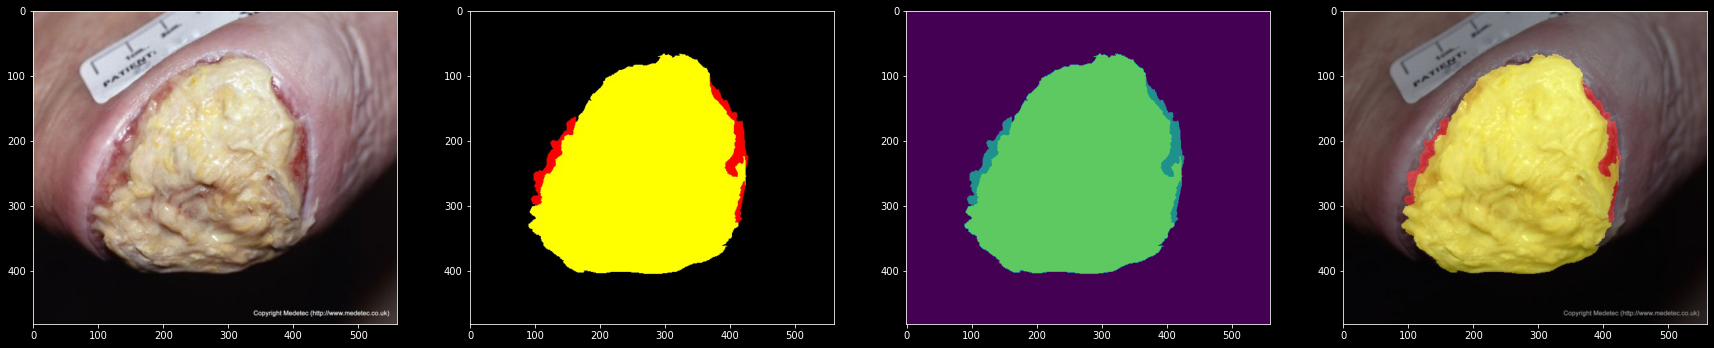

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(30,10))
nroImg = 2
img = np.load(imgs[nroImg])
mask = np.load(masks[nroImg])
maskRGBPuro = np.load(masksRGBPuros[nroImg]) # para confirmar que se vea como mask.

maskClaseX1 = np.load(masksClaseX1[nroImg])
maskHxW = np.squeeze(maskClaseX1, axis=2) # imshow me las da segmentadas estando en H x W , con valores entre 0 y 4


ax1.imshow(img)
ax2.imshow(mask)
ax3.imshow(maskHxW)
ax4.imshow(img)
ax4.imshow(mask, alpha=0.4)
plt.show()


# Pruebo hacer un fit


In [ ]:
maskClaseXN = np.load(masksClaseX1[0])
maskClaseXN.shape, maskClaseXN.dtype, maskClaseXN.max(), maskClaseXN.min()

((443, 560, 1), dtype('float64'), 4.0, 0.0)

In [ ]:
norMaskClaseXN = (maskClaseXN)/255
norMaskClaseXN.shape, norMaskClaseXN.dtype, norMaskClaseXN.max(), norMaskClaseXN.min()

((443, 560, 1), dtype('float64'), 0.01568627450980392, 0.0)